# An introduction to model discovery

### by Georges Tod
### March 2021

In [1]:
import numpy as np
import matplotlib.pylab as plt
from time import time
import seaborn as sns
from matplotlib import rc, font_manager

In [2]:
# some formatting
font_size=24
ticks_font = font_manager.FontProperties(size=font_size)
sns.set(font_scale=1.5)
sns.set_style("white")


# Introduction

In this notebook, I am sharing some material to do some basic model discovery.

First, I am sharing here a couple of libraries for the KdV and Burgers' equations. These libraries contain the following terms:

name_feats = ['$1$', r'$u_x$', '$u_{xx}$', '$u_{xxx}$', '$u$', '$u u_{x}$', '$u u_{xx}$', '$u u_{xxx}$', '$u^2$', '$u^2 u_{x}$', '$u^2 u_{xx}$', '$u^2 u_{xxx}$']

They have been obtained using automatic differentiation from analytical solutions - they do not contain any additional noise.


In the second part of the notebook, I propose to start with the Burgers' equation.

In [3]:
# library definition
name_feats = [r'$1$', r'$u_x$', '$u_{xx}$', '$u_{xxx}$', '$u$', '$u u_{x}$', '$u u_{xx}$', '$u u_{xxx}$', '$u^2$', '$u^2 u_{x}$', '$u^2 u_{xx}$', '$u^2 u_{xxx}$']


# Kortweg-de-Vries equation

This dataset is not extensively used in this notebook but can be a good starting point to exercice yourself.

## loading a library

In [4]:
theta = np.load('data/kdv_theta_GT.npy')[[1,3]] # making sure i only have double solitons
dt    = np.load('data/kdv_dt_GT.npy')[[1,3]]

## u plot

Text(0.5, 1.0, 'u(x,t)')

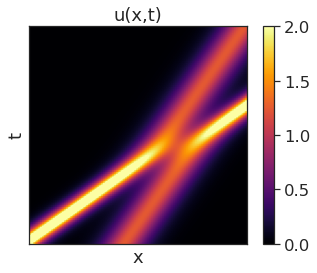

In [5]:
plt.imshow(theta[0,:,4].reshape(100,100).T,origin='lower',vmin=0,vmax=2,cmap='inferno')
plt.yticks([])
plt.xticks([])
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.title('u(x,t)')


## at t1

In [6]:
Xs = theta[0,:,4].reshape(100,100).T

Text(0.5, 0, 'x')

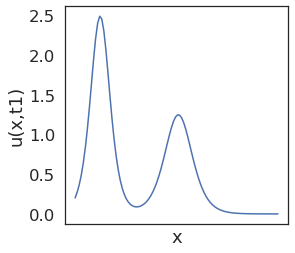

In [7]:
plt.figure(figsize=(4,4))
plt.plot(Xs[10,:])
plt.xticks([])
plt.ylabel('u(x,t1)')
plt.xlabel('x')


## somewhere in the middle

Text(0.5, 0, 'x')

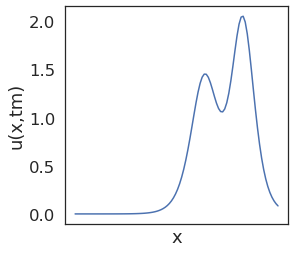

In [8]:
plt.figure(figsize=(4,4))
plt.plot(Xs[50,:])
plt.xticks([])
plt.ylabel('u(x,tm)')
plt.xlabel('x')


# Burgers' equation

In [9]:
theta = np.load('data/burgers_theta_GT.npy')
dt    = np.load('data/burgers_dt_GT.npy')

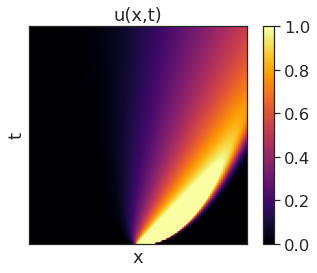

In [10]:
plt.imshow(theta[0,:,4].reshape(100,100).T,origin='lower',vmin=0,vmax=1,cmap='inferno')
plt.yticks([])
plt.xticks([])
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')

plt.colorbar()

In [11]:
Xs = theta[0,:,4].reshape(100,100).T

In [12]:
Xs.shape

(100, 100)

Text(0.5, 0, 'x')

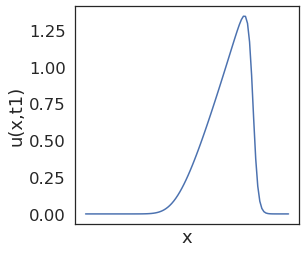

In [13]:
plt.figure(figsize=(4,4))
plt.plot(Xs[20,:])
plt.xticks([])
plt.ylabel('u(x,t1)')
plt.xlabel('x')


Text(0.5, 0, 'x')

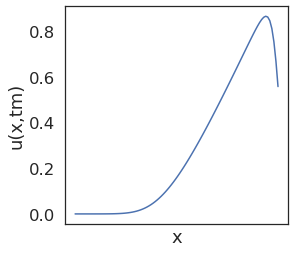

In [14]:
plt.figure(figsize=(4,4))
plt.plot(Xs[50,:])
plt.xticks([])
plt.ylabel('u(x,tm)')
plt.xlabel('x')


## let's plot the content of the library

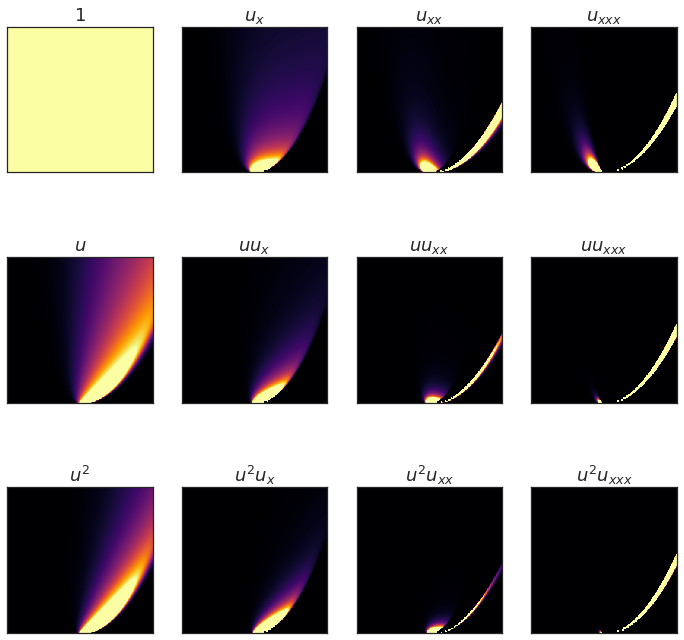

In [15]:

fig, ax = plt.subplots(3,4,figsize=(12,12))

term=0
for i in range(3):
    for j in range(4):
        im=ax[i,j].imshow(theta[0,:,term].reshape(100,100).T,origin='lower',vmin=0,vmax=1,cmap='inferno')
        ax[i,j].set_title(name_feats[term])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
        
        term+=1

## Let's stick to a library and time derivative

In [16]:
X = theta[0,:,:]
y = dt[0,:,:]
print(X.shape,y.shape)

(10000, 12) (10000, 1)


## First things first, let's apply some ordinary least-squares

In [17]:
betaOLS = np.linalg.lstsq(X,y,rcond=1)[0]
print(betaOLS)

[[ 4.08673930e-16]
 [-2.27568615e-15]
 [ 1.00000000e-01]
 [-8.66499458e-16]
 [-3.79222855e-15]
 [-1.00000000e+00]
 [-4.51097137e-16]
 [ 9.91475782e-16]
 [ 1.29163451e-15]
 [-1.17606550e-15]
 [ 4.10319700e-16]
 [-1.63660318e-16]]


by the way, OLS is simply the Ridge regression without regularization,

In [18]:
def homemade_Ridge(X,y, lambdaC):
    M1 = (X.T @ X + lambdaC*np.eye(X.shape[1])) 
    M2 =  X.T @ y
    beta = np.linalg.inv(M1) @ M2
    return beta


In [19]:
homemade_Ridge(X,y,0)

array([[ 5.33706412e-12],
       [-1.81188398e-13],
       [ 1.00000000e-01],
       [ 2.77555756e-16],
       [ 3.16191517e-13],
       [-1.00000000e+00],
       [ 1.25455202e-13],
       [-2.08166817e-15],
       [-9.23705556e-14],
       [ 8.30446822e-14],
       [-2.75335310e-14],
       [ 8.11850587e-16]])

The actual physical parameter used to generate the data, i.e. the viscosity is $\nu=0.1$.

**Conclusions**

If we remove the very small terms, this approximation is very good! But this will not hold with noisy data: it will be harder to distinguish small from not that small.

All coefficients are nonzero: OLS uses every term in the library to propose a PDE. However, irrelevant terms are small and relevant terms (2 (viscosity) and 5 (nonlinear advection)) are large, let's visualize this.



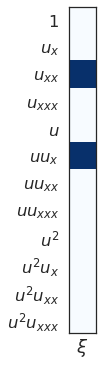

In [20]:
fig,ax = plt.subplots(figsize=(4, 6))

ax.imshow(np.abs(betaOLS),origin='upper',cmap=plt.cm.Blues, vmin=0, vmax=0.1);
ax.tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False )
ax.set_yticks(range(betaOLS.shape[0]))
ax.set_yticklabels(name_feats)
ax.set_xlabel(r'$\xi$');
fig.show()

## Comparing some Ridge regression and the Lasso

Importing Ridge and Lasso from scikit learn,

In [21]:
from sklearn.linear_model import Lasso, LassoCV, Ridge

#### Normalizing the data

It is important to normalize the data before using Ridge or the Lasso

In [22]:
xn = np.linalg.norm(X,axis=0,keepdims=True)
yn = np.linalg.norm(y,axis=0,keepdims=True)

Xn = X/xn
yn = y/yn
print(Xn.shape,yn.shape)

(10000, 12) (10000, 1)


Let's now redo some OLS and extract the relevant terms to have some idea of the ground truth using normalized data,

In [23]:
ground_truth_vector = (np.linalg.lstsq(Xn,yn,rcond=1)[0])
ground_truth_vector[[2,5]]

array([[ 0.73917691],
       [-1.0617772 ]])

Let's call this the ground truth,

In [24]:
ground_truth = (np.linalg.lstsq(Xn,yn,rcond=1)[0])[[2,5]]

The first value is the viscosity and the second is the coefficient in front of the non linear advection term. Now, what do we obtain using some Ridge regression,

#### some Ridge regression

In [25]:
alphas = np.logspace(-7, 0, 50, base=10)
beta_path = np.array([homemade_Ridge(Xn,yn,alpha) for alpha in alphas])[:,:,0]

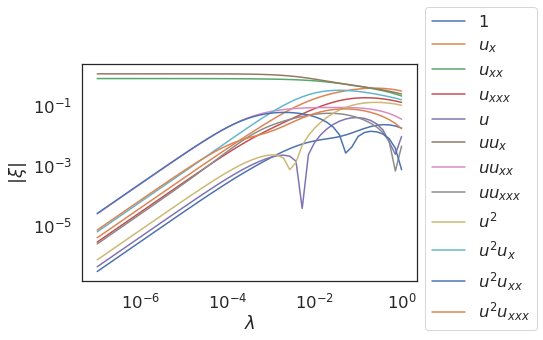

In [26]:
plt.plot(alphas,np.abs(beta_path));
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$|\xi|$')
plt.legend(name_feats,bbox_to_anchor=(1, 1.3));

Now let's use some scikit learn to verify our homemade Ridge,

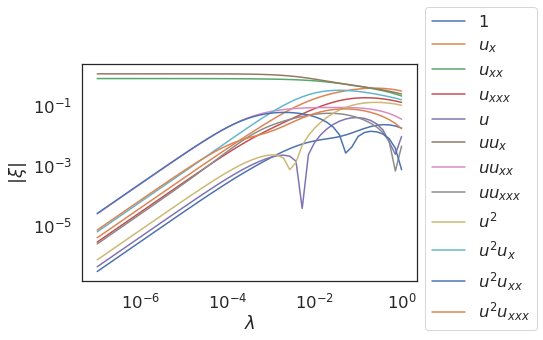

In [27]:
beta_pathSL = np.array([Ridge(alpha=alpha,fit_intercept=False).fit(Xn,yn).coef_ for alpha in alphas])[:,0,:]
plt.plot(alphas,np.abs(beta_pathSL));
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$|\xi|$')
plt.legend(name_feats,bbox_to_anchor=(1, 1.3));

**Conclusion**,
all coefficients are nonzero with both OLS and the Ridge (no matter the regularization)! 

#### the almighty Lasso

In [28]:
beta_pathLASSO = np.array([Lasso(alpha=alpha,fit_intercept=False).fit(Xn,yn).coef_ for alpha in alphas])

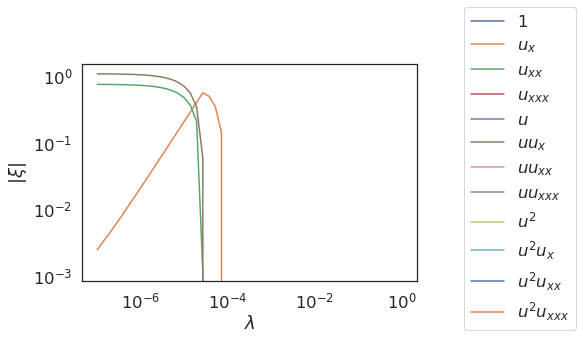

In [29]:
plt.plot(alphas,np.abs(beta_pathLASSO));
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$|\xi|$')
plt.legend(name_feats,bbox_to_anchor=(1.5, 1.3));

Lots of terms have become zero: we get a **PARSIMONIOUS** model ! What about the magnitude of the coefficients?

From this very first observations it seems a good idea to choose $\lambda < 10^{-6}$

In [30]:
Lasso(alpha=1e-6,fit_intercept=False).fit(Xn,yn).coef_

array([ 0.        , -0.02089353,  0.71140524, -0.        , -0.        ,
       -1.02393431,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ])

And let's recall the ground truth,

In [31]:
ground_truth

array([[ 0.73917691],
       [-1.0617772 ]])

There is some shrinkage. Now let's compare how well they perform. First we compute the residual error using the OLS result,

In [32]:
np.mean((yn - Xn@ground_truth_vector)**2)

1.8141426524270854e-33

and second, our Lasso result,

In [33]:
np.mean((yn - Xn@Lasso(alpha=1e-6,fit_intercept=False).fit(Xn,yn).coef_)**2)

0.00019642140959824173

Conclusions

1. The Lasso produces a sparse vector and somehow it has **SELECTED** the most important features (even though a small additional term was not removed - we will come back on this).

2. Another property of the Lasso (Least Absolute Shrinkage and Selection Operator) is that it tends to **SHRINK** the coefficients, in this example the effect is small, but still!



## What is a good value of $\lambda$ for the Lasso ?

In the previous section we have plotted the coefficient one would obtain for varying values of $\lambda$. As a remainder, $\lambda \rightarrow 0$ is again OLS,

In [34]:
Lasso(alpha=0,fit_intercept=False).fit(Xn,yn).coef_

<ipython-input-34-053500cf9c33>:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  Lasso(alpha=0,fit_intercept=False).fit(Xn,yn).coef_
/home/georges/anaconda3/envs/jaxSon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


array([ 9.39754087e-04, -5.73170474e-03,  7.05884666e-01, -1.12130644e-02,
       -2.43368375e-03, -1.05428177e+00,  1.29478439e-01,  1.94755754e-02,
        4.84991960e-03, -6.28573337e-03, -1.32892820e-01,  2.23681650e-02])

Even though scikit learn does not seem to like it. 

And if we setup $\lambda \rightarrow \infty$, we will obtain maximum sparsity, aka the null vector,

In [35]:
Lasso(alpha=10,fit_intercept=False).fit(Xn,yn).coef_

array([-0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])

So what is a good value of $\lambda$ ? There are lots of methods to go abou this, (too) classically people go for the cross validation. Let's see how it performs. Look at the slides to grasp why we hope the result from CV will be generalizable,

### **$k$-fold Cross validation**

The residual error on each fold is computed by first fitting $\hat{\beta}_{(-k)}$ using all data excluding the $k^{th}$ fold, that we denote $(-k)$. 

Second the residual error is computed using the data from the the $k^{th}$ fold (not used to fit the coefficients),

\begin{equation}
RE_k(\lambda) = \frac{1}{2n_{(-k)}}||Y_{k}-X_{k}\hat{\beta}_{(-k)}(\lambda)||_{F}^{2}
\end{equation}


The operation is repeated $k$ times. As very often in literature 10 folds are selected, by default LassoCV takes 5,

\begin{equation}
\lambda_{RE-CV} = \argmin_{\lambda}  \Big (\frac{1}{k} \sum_k RE_k(\lambda) \Big )
\end{equation}

And below we take 20 folds, I recommend playing around with this value and realize the result should not be sensitive to it.


In [36]:
yolo = LassoCV(cv=20,fit_intercept=False).fit(Xn,yn.ravel())

Text(0, 0.5, '$MSE$')

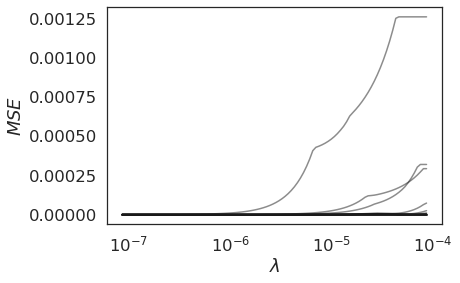

In [37]:
plt.plot(yolo.alphas_,yolo.mse_path_,'-k',alpha=0.5)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$MSE$')


From $\lambda < 10^{-6}$ it seems to have reached a minimum.
The best the Lasso can do according to the cross validation is achieved with $\lambda$,

In [38]:
yolo.alpha_

8.617471634271639e-08

And the best PDE we can recover will be obtained from,

In [39]:
yolo.coef_

array([ 0.        , -0.00199836,  0.73666126, -0.        , -0.        ,
       -1.05831276,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ])

Now there is a coefficient there which still very very small and if you remember correctly, we are working with normalized data, so here the coefficients are dimensionless: usually people in the community would usually set an ad hoc threshold, let's say 0.1 and remove everything below to get the final PDE,

In [40]:
PDE_coeffs = yolo.coef_[np.abs(yolo.coef_)>0.1]
PDE_coeffs

array([ 0.73666126, -1.05831276])

If we compare again to the ground truth and our previous result, there is less shrinkage than in our previous attempt,

In [41]:
ground_truth

array([[ 0.73917691],
       [-1.0617772 ]])

This is not bad, but we can do better. Below, we leave the state of the art to some more advanced topic.

## Can we more elegantly select the true model from the library?

Yes. There is a more intricate reason why the Lasso does come up with that very small term. The reason is because the Lasso is not consistent for every design matrix X. A variable selection method is said to be consistent if, when the sample size tends to infinity and the true model is present in the library then it will be selected.

The adaptive Lasso (reference in the slides) is known to be consistent. Let's illustrate this,

Scikit-learn does not propose any adaptive Lasso, but we can propose some ourselves,


In [42]:
def minimal_adaptive_Lasso(X,y,alphas,super_power:float=2):
    
    def coeffs(alpha):
        n_samples, n_features = X.shape
        # initial weights
        weights = (np.abs(Ridge(alpha=1e-4,fit_intercept=False).fit(X, y).coef_).ravel())**super_power
        X_w = X * weights[np.newaxis, :]
        clf = Lasso(alpha=alpha, fit_intercept=False)
        clf.fit(X_w, y)
        coef_ = clf.coef_ * weights
        return coef_
    
    betas = [coeffs(alpha) for i, alpha in enumerate(alphas)]
    
    return betas

In [43]:
beta_path_adaLASSO = minimal_adaptive_Lasso(Xn,yn,alphas)

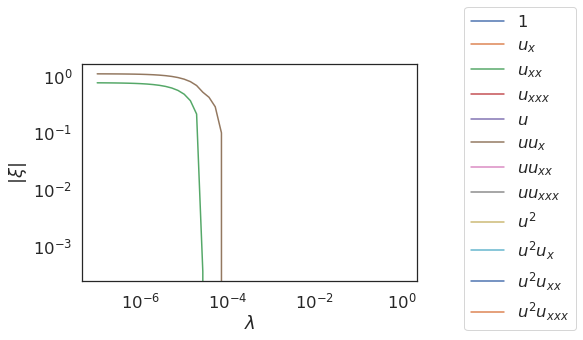

In [44]:
plt.plot(alphas,np.abs(beta_path_adaLASSO));
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$|\xi|$')
plt.legend(name_feats,bbox_to_anchor=(1.5, 1.3));

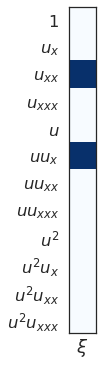

In [45]:
fig,ax = plt.subplots(figsize=(4, 6))

ax.imshow(np.abs(beta_path_adaLASSO[0].reshape(-1,1)),origin='upper',cmap=plt.cm.Blues, vmin=0, vmax=0.1);
ax.tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False )
ax.set_yticks(range(betaOLS.shape[0]))
ax.set_yticklabels(name_feats)
ax.set_xlabel(r'$\xi$');
fig.show()

# Exercices
At the beginning of this notebook we loaded the data for 2 cases: the KdV equation and Burgers' equation. 
In this notebook, I only described how to discover the Burgers' equation.

1. Try discovering the KdV PDE by yourself.
2. To investigate the impact of noise on classical model discovery: add 1% noise on top of the data (very first heatmap), then build your own library and time derivative using numerical differentiation and try discovering the equation. Increase the noise, you should to get into the troubles described in the slides.